In [2]:
!pip install wget
!pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/63/ae/70fc292ccf056a9945e0f4591c29bbc5f018967e06eeb3f5a9449e0defff/catboost-1.2.5-cp39-cp39-macosx_11_0_universal2.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.3/26.3 MB 6.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.0 MB/s eta 0:00:00


In [3]:
# import os,sys

# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append("/content/drive/My Drive/Collab/collab_v1")
# %cd "/content/drive/My Drive/Collab/collab_v1"

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
#some plotting routines
import plotting

# data processing
import data_higgs as dh

from catboost import CatBoostClassifier, Pool
# from google.colab import output
# output.enable_custom_widget_manager()

In [6]:
#--------- globals

# Need to see a large portion of the data before we can build a layer, for
# example half of data n_batches_per_layer =  NBATCH_FRAC * NUM_EXAMPLES / BATCH_SIZE
BATCH_SIZE = 1000

# Seed value
# Apparently you may use different seed values at each stage
SEED_VALUE= 10001
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)
# # 4. Set `tensorflow` pseudo-random generator at a fixed value
# tf.random.set_seed(SEED_VALUE)

In [7]:
#-------- routines

def split_xy(rawdata):
    #split features and labels from data
    #prepare the data => normalizations !

    # split
    data_y=rawdata['hlabel'] # labels only: 0.=background, 1.=signal
    data_x=rawdata.drop(['hlabel'], axis=1) # features only
    
    #now prepare the data
    mu = data_x.mean()
    s = data_x.std()
    dmax = data_x.max()
    dmin = data_x.min()

    # normal/standard rescaling
    data_x = (data_x - mu)/s

    #scaling to [-1,1] range
    #data_x = -1. + 2.*(data_x - dmin)/(dmax-dmin)

    # scaling to [0,1] range
    #data_x = (data_x - dmin)/(dmax-dmin)


    return data_x,data_y

Loading /Users/lukapuslar/Desktop/school/3_letnik/Mafi_prak/12_naloga_ML/material/ML_folder/drive-download-20240825T205927Z-001/data/higgs-parsed/higgs-parsed.h5...
Loaded.
['/feature_names', '/train', '/valid']
0             hlabel
1          lepton-pT
2         lepton-eta
3     missing-energy
4           jet_1-pt
5          jet_1-eta
6           jet_2-pt
7          jet_2-eta
8           jet_3-pt
9          jet_3-eta
10          jet_4-pt
11         jet_4-eta
12              m_jj
13             m_jjj
14              m_lv
15             m_jlv
16              m_bb
17             m_wbb
18            m_wwbb
dtype: object
   hlabel  lepton-pT  lepton-eta  missing-energy  jet_1-pt  jet_1-eta  \
0     1.0   0.869293   -0.635082        0.327470  0.754202  -0.248573   
1     1.0   0.907542    0.329147        1.497970  1.095531  -0.557525   
2     1.0   0.798835    1.470639        0.453773  1.104875   1.282322   
3     0.0   1.344385   -0.876626        1.992050  1.786066  -1.646778   
4     1.0 

Text(0.5, 1.0, 'Korelacijska matrika')

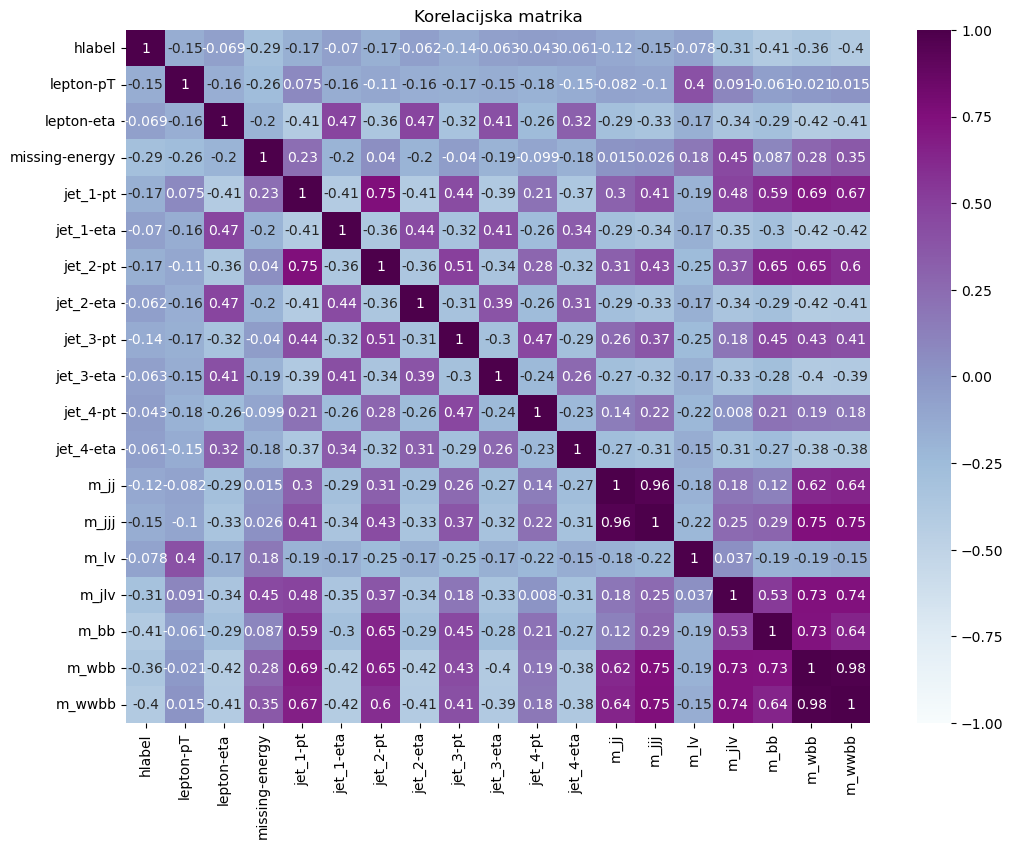

In [49]:
# store.close()
# print(store)
hdata = dh.load_data()
type(hdata)
# store = pd.HDFStore(hdata)
print(hdata.keys())
print(hdata['/feature_names'])
# print(hdata['/feature_names'].head())
print(hdata['/train'].head())
print(hdata['/train'].size)
print(hdata['/train'].shape)

df_hdata = hdata['/train']
df_corr_columns =['hlabel', 'lepton-pT', 'lepton-eta', 'missing-energy', 'jet_1-pt',
       'jet_1-eta', 'jet_2-pt', 'jet_2-eta', 'jet_3-pt', 'jet_3-eta',
       'jet_4-pt', 'jet_4-eta', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb',
       'm_wbb', 'm_wwbb']
#  ['hmass', 'pt1', 'eta1', 'phi1', 'pt2', 'eta2', 'phi2', 'ptmiss', 'phimiss', 'dphimiss', 'detamiss', 'sumpt', 'dphi', 'deta', 'zepp1', 'zepp2']
# plt.figure()
print(df_hdata.columns)
corr_df = df_hdata[df_corr_columns].corr()

corr = corr_df.corr(method= 'pearson') # Pearson (default)


corr = corr_df.corr(method= 'pearson') # Pearson (default)
# df.corr(method='kendall')  # Kendall Tau
# df.corr(method='spearman') # Spearman Rank

plt.figure(figsize=(12,9))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="BuPu",
            vmin=-1,
            vmax=1,
            annot=True)
plt.title("Korelacijska matrika")


# store.close()

In [52]:
def main(nepoch=100):
        # Training progress and eval results are shown as logging.INFO; so enables it.

    #needs to be done once if the h5 files need to be recreated...
    #dh.download_and_make_data()

    hdata=dh.load_data()
    data_fnames=hdata['feature_names'].to_numpy()[1:] #labels not needed
    n_dims=data_fnames.shape[0]
    print ("Entries read {} with feature names {}".format(n_dims,data_fnames))

    x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
    x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
    x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample

    print("Shapes train:{} and test:{}".format(x_train.shape,x_test.shape))

    #plot distributions
    plotting.plot_sig_bkg_from_np_arrays(x_train.to_numpy(),y_train.to_numpy(),data_fnames,logy=False)

    # ready the data for Catboost
    pool_train = Pool(data=x_train.to_numpy(),label=y_train.to_numpy(),feature_names=data_fnames.tolist())
    pool_test = Pool(data=x_test.to_numpy(),label=y_test.to_numpy(),feature_names=data_fnames.tolist())

    #NaKratko .... !

    # CatBoost parameters
    eval_metric = 'AUC' # see https://catboost.ai/docs/concepts/loss-functions-classification.html
    task_type = 'CPU'  # if GPU else 'CPU'
    max_number_of_trees = nepoch
    #eval_metric = 'Accuracy'
    bdt=CatBoostClassifier(
        verbose=True,
        task_type=task_type,
        loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
        iterations=max_number_of_trees,
        eval_metric=eval_metric,
        learning_rate=0.01,
        max_depth=6,
        use_best_model=False,
        random_seed=SEED_VALUE,
        )

    #now train the model
    bdt.fit(
            pool_train,
            early_stopping_rounds=20,
            #is early stopping relevant?
            eval_set=pool_test,
            plot=True # works when called through Ipython/jupyter
        )


    print()
    #plot & print results like ROC and score distribution etc...
    y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
    print("score shape {}",y_score.shape)
    plotting.plot_roc(y_val,y_score)
    plotting.plot_score(y_val,y_score)
    auc=roc_auc_score(y_val,y_score)
    print("AUC score: {}".format(auc))

In [53]:
main(50)

Loading /Users/lukapuslar/Desktop/school/3_letnik/Mafi_prak/12_naloga_ML/material/ML_folder/drive-download-20240825T205927Z-001/data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7122533	best: 0.7122533 (0)	total: 51ms	remaining: 2.5s
1:	test: 0.7262420	best: 0.7262420 (1)	total: 70.4ms	remaining: 1.69s
2:	test: 0.7281936	best: 0.7281936 (2)	total: 88.1ms	remaining: 1.38s
3:	test: 0.7288024	best: 0.7288024 (3)	total: 102ms	remaining: 1.17s
4:	test: 0.7285312	best: 0.7288024 (3)	total: 115ms	remaining: 1.03s
5:	test: 0.7285533	best: 0.7288024 (3)	total: 127ms	remaining: 934ms
6:	test: 0.7284961	best: 0.7288024 (3)	total: 140ms	remaining: 862ms
7:	test: 0.7297194	best: 0.7297194 (7)	total: 161ms	remaining: 844ms
8:	test: 0.7300378	best: 0.7300378 (8)	total: 179ms	remaining: 816ms
9:	test: 0.7304546	best: 0.7304546 (9)	total: 202ms	remaining: 806ms
10:	test: 0.7304536	best: 0.7304546 (9)	total: 217ms	remaining: 770ms
11:	test: 0.7304438	best: 0.7304546 (9)	total: 234ms	remaining: 741ms
12:	test: 0.7307562	best: 0.7307562 (12)	total: 250ms	remaining: 711ms
13:	test: 0.7305114	best: 0.7307562 (12)	total: 268ms	remaining: 690ms
14:	test: 0.7307545	best: 0.

In [14]:
!pip install tables 




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 3.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for numexpr>=2.6.2 from https://files.pythonhosted.org/packages/7f/d9/0e70a729a64917feebc3aca0081daa29782f71b0a93fd883cd34cee02ec7/numexpr-2.10.1-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for blosc2>=2.3.0 from https://files.pythonhosted.org/packages/07/cb/e97de5b2c40b6c2106d5b68c1d823707a16386fc08781a6c7c609000866e/blosc2-2.5.1-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Using cached blosc2-2.5.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Obtaining dependency information for ndindex>=1.4 from https://files.pythonhosted.org/packages/4c/1f/cbec4cb91b5aa7e44a539a92ec76293ababe9a6dd123c52a0e416d50dc81/ndindex-1.8-py3-none-any.whl.metadata
  Using cached ndindex-1.8-py3-none-any.whl.metadata (3.